# Análisis Exploratorio de Datos - Mercado Inmobiliario

Este cuaderno realiza la limpieza y análisis exploratorio de los datos scrapeados de ZonaProp.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast

# Configuración de estilo
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)

pd.set_option('display.max_colwidth', None)

## 1. Carga de Datos
En esta sección cargaremos los datos desde el archivo CSV.

In [11]:
# Leemos el dataset
try:
    df = pd.read_csv("../data/raw/real_estate_listings.csv")
    print(f"Dimensiones iniciales: {df.shape}")
    display(df.head())
except FileNotFoundError:
    print("Archivo no encontrado. Verifica la ruta.")

Dimensiones iniciales: (29999, 6)


,price,location,features,expensas,description,url
0,USD 109.000,"Palermo, Capital Federal","['32 m² tot.', '2 amb.', '1 dorm.', '1 baño']",$ 125.000 Expensas,Departamento de dos ambientes con cocina separ...,https://www.zonaprop.com.ar/propiedades/clasif...
1,USD 95.243,"Villa Devoto, Capital Federal","['39 m² tot.', '1 amb.', '1 baño', '1 coch.']",$ 50.000 Expensas,Venta departamento monoambiente A estrenar en ...,https://www.zonaprop.com.ar/propiedades/clasif...
2,USD 190.000,"Villa Urquiza, Capital Federal","['62 m² tot.', '2 amb.', '1 dorm.', '1 baño']",$ 1 Expensas,Edificio Atrium Boulevard en esquina ubicado e...,https://www.zonaprop.com.ar/propiedades/clasif...
3,USD 133.984,"Belgrano, Capital Federal","['78 un.', '1 a 3 amb.', '35 a 169 m² tot.', '...",NaN,Imponente Proyecto de viviendas de gran catego...,https://www.zonaprop.com.ar/propiedades/empren...
4,USD 175.000,"Villa Urquiza, Capital Federal","['94 m² tot.', '2 amb.', '1 dorm.', '1 baño', ...",$ 150.000 Expensas,Venta departamento unico de 2 ambientes con ba...,https://www.zonaprop.com.ar/propiedades/clasif...


## 2. Limpieza y Procesamiento de Datos
En esta sección limpiaremos y procesaremos los datos para poder utilizarlos de forma apropiada.

In [37]:
# 1. Limpieza de strings
df['features_clean'] = df['features'].str.replace(r"[[\]']", "", regex=True)
# Aseguramos que la descripcion sea string para evitar errores con nulos
df['description'] = df['description'].fillna('')

# 2. Función de extracción general
def extract_opt(text, pattern):
    match = re.search(fr'(\d+)\s*(?:{pattern})', text, re.IGNORECASE)
    return int(match.group(1)) if match else 0

# 3. Extracción de features 
df['m2'] = df['features_clean'].apply(lambda x: extract_opt(x, 'm²|metros'))
df['ambientes'] = df['features_clean'].apply(lambda x: extract_opt(x, 'amb'))
df['baños'] = df['features_clean'].apply(lambda x: extract_opt(x, 'baños'))
df['dormitorios'] = df['features_clean'].apply(lambda x: extract_opt(x, 'dorm'))
df['cocheras'] = df['features_clean'].apply(lambda x: extract_opt(x, 'coch'))

# 4. Limpieza de precio 
df['precio_usd'] = pd.to_numeric(df['price'].str.replace(r'[^0-9]', '', regex=True), errors='coerce')

# 5. Filtrado y Limpieza Final
df_clean = df.dropna(subset=['precio_usd']).copy()
df_clean['ubicación'] = df_clean['location']

df_clean['baños'] = df_clean['baños'].replace(0,1)

cols_finales = ['precio_usd', 'ubicación', 'm2', 'ambientes', 'dormitorios', 'baños', 'cocheras', 'expensas', 'url']
df_clean = df_clean[cols_finales].fillna(0)

df_clean.head()

,precio_usd,ubicación,m2,ambientes,dormitorios,baños,cocheras,expensas,url
0,109000.0,"Palermo, Capital Federal",32,2,1,1,0,$ 125.000 Expensas,https://www.zonaprop.com.ar/propiedades/clasif...
1,95243.0,"Villa Devoto, Capital Federal",39,1,0,1,1,$ 50.000 Expensas,https://www.zonaprop.com.ar/propiedades/clasif...
2,190000.0,"Villa Urquiza, Capital Federal",62,2,1,1,0,$ 1 Expensas,https://www.zonaprop.com.ar/propiedades/clasif...
3,133984.0,"Belgrano, Capital Federal",169,3,0,1,0,0,https://www.zonaprop.com.ar/propiedades/empren...
4,175000.0,"Villa Urquiza, Capital Federal",94,2,1,1,1,$ 150.000 Expensas,https://www.zonaprop.com.ar/propiedades/clasif...


## 3. Análisis Exploratorio de Datos (EDA)
En esta sección generaremos nuevas variables y realizaremos un análisis exhaustivo de los datos inmobiliarios.

In [13]:
# 1. Feature Engineering: Creación de nuevas variables

# Precio por m2 (Dólares / m2)
# Filtramos propiedades con m2 > 0 para evitar divisiones por cero
df_clean = df_clean[df_clean['m2'] > 0].copy()
df_clean['precio_m2'] = df_clean['precio_usd'] / df_clean['m2']

# Relación cantidad de ambientes por m2
df_clean['ambientes_m2'] = df_clean['ambientes'] / df_clean['m2']

# Extracción del nombre del Barrio desde la columna 'ubicación'
df_clean['barrio'] = df_clean['ubicación'].apply(lambda x: x.split(',')[0].strip() if isinstance(x, str) else 'Desconocido')

print(f"Cantidad de barrios identificados: {df_clean['barrio'].nunique()}")
print("Variables creadas: precio_m2, ambientes_m2, barrio")
display(df_clean[['ubicación', 'barrio', 'precio_usd', 'm2', 'precio_m2']].head())

Cantidad de barrios identificados: 82
Variables creadas: precio_m2, ambientes_m2, barrio


,ubicación,barrio,precio_usd,m2,precio_m2
0,"Palermo, Capital Federal",Palermo,109000.0,32,3406.250000
1,"Villa Devoto, Capital Federal",Villa Devoto,95243.0,39,2442.128205
2,"Villa Urquiza, Capital Federal",Villa Urquiza,190000.0,62,3064.516129
3,"Belgrano, Capital Federal",Belgrano,133984.0,169,792.804734
4,"Villa Urquiza, Capital Federal",Villa Urquiza,175000.0,94,1861.702128


### 3.1 Identificación de Valores Atípicos (Outliers)
Visualizamos la distribución de las variables clave para detectar valores extremos que puedan sesgar el análisis.

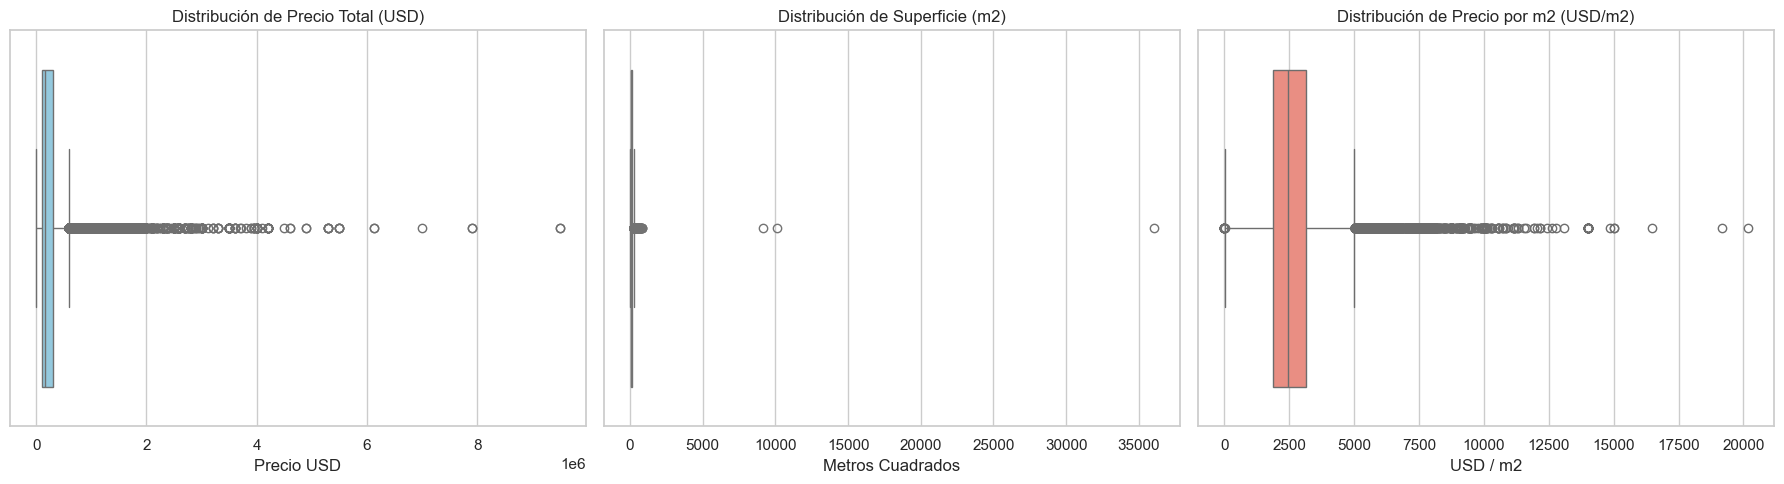

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Boxplot Precio Total
sns.boxplot(x=df_clean['precio_usd'], ax=axes[0], color='skyblue')
axes[0].set_title('Distribución de Precio Total (USD)')
axes[0].set_xlabel('Precio USD')

# Boxplot Superficie
sns.boxplot(x=df_clean['m2'], ax=axes[1], color='lightgreen')
axes[1].set_title('Distribución de Superficie (m2)')
axes[1].set_xlabel('Metros Cuadrados')

# Boxplot Precio m2
sns.boxplot(x=df_clean['precio_m2'], ax=axes[2], color='salmon')
axes[2].set_title('Distribución de Precio por m2 (USD/m2)')
axes[2].set_xlabel('USD / m2')

plt.tight_layout()
plt.show()


### 3.2 Segmentación Geográfica
Analizamos el precio promedio y el valor del m² agrupados por barrio. Esto permite identificar zonas premium y oportunidades de inversión.

Top 10 Barrios más caros por m2:


,precio_usd,precio_m2,cantidad
barrio,,,
Puerto Madero,9.060505e+05,5600.809251,1013
Barrio Parque,1.500413e+06,4983.075950,46
Palermo Nuevo,7.771168e+05,4451.867216,76
Palermo Chico,6.951549e+05,4151.005749,742
Distrito Quartier,1.953000e+05,3804.150548,5
Belgrano Chico,3.833254e+05,3575.372423,18
Núñez,4.126112e+05,3400.703596,1351
Las Cañitas,3.916301e+05,3275.931866,577
Palermo,3.872280e+05,3204.562379,2460


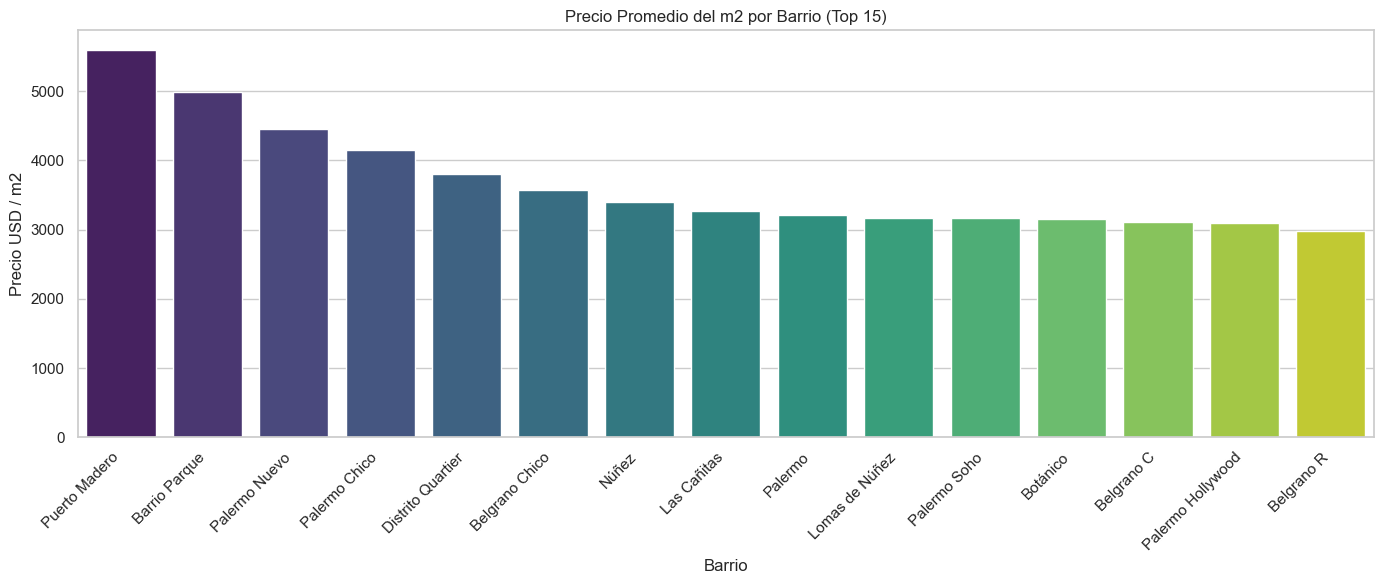

In [15]:
# Agrupamos por barrio y calculamos medias
barrio_stats = df_clean.groupby('barrio').agg({
    'precio_usd': 'mean',
    'precio_m2': 'mean',
    'ubicación': 'count'  # Cantidad de propiedades
}).rename(columns={'ubicación': 'cantidad'}).sort_values('precio_m2', ascending=False)

# Filtramos solo barrios con una cantidad mínima representativa de datos
barrio_stats = barrio_stats[barrio_stats['cantidad'] > 0]

print("Top 10 Barrios más caros por m2:")
display(barrio_stats.head(10))

# Visualización de los Top 15 Barrios por Precio m2
plt.figure(figsize=(14, 6))
top_barrios = barrio_stats.head(15)
sns.barplot(x=top_barrios.index, y=top_barrios['precio_m2'], hue=top_barrios.index, palette='viridis', legend=False)
plt.xticks(rotation=45, ha='right')
plt.title('Precio Promedio del m2 por Barrio (Top 15)')
plt.ylabel('Precio USD / m2')
plt.xlabel('Barrio')
plt.tight_layout()
plt.show()

### 3.3 Drivers de Valor: Impacto de Cocheras y Baños
Evaluamos cómo la presencia de cochera y la cantidad de baños influyen en el precio de la propiedad.

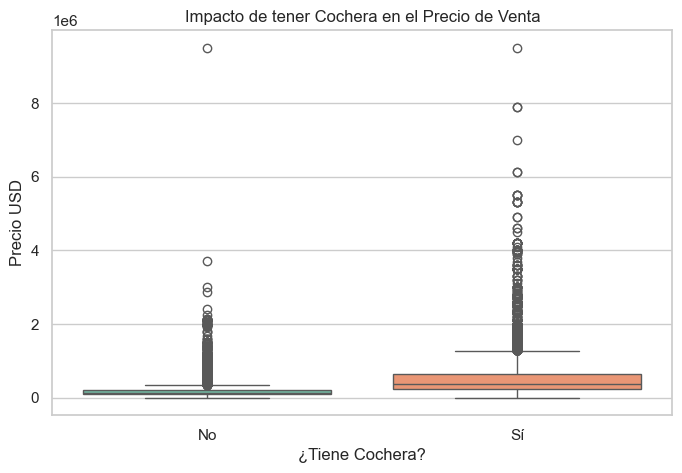

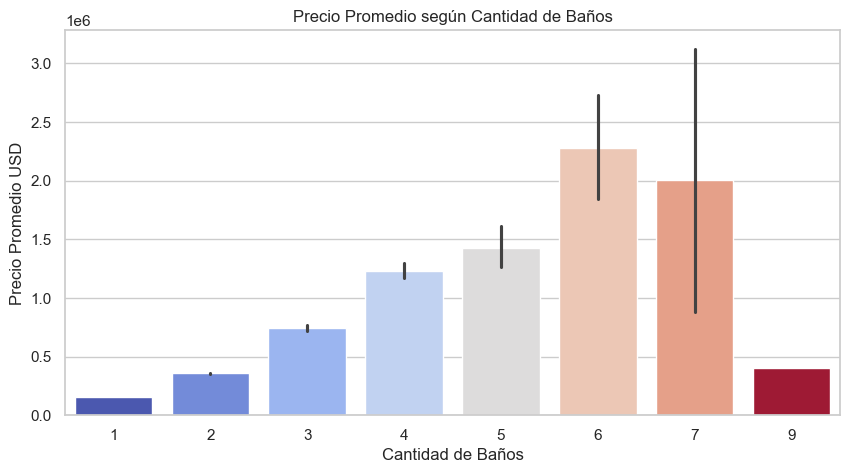

In [16]:
# Crear variable categórica para 'Tiene Cochera'
df_clean['tiene_cochera'] = df_clean['cocheras'].apply(lambda x: 'Sí' if x > 0 else 'No')

# Visualización: Precio vs Cochera
plt.figure(figsize=(8, 5))
sns.boxplot(x='tiene_cochera', y='precio_usd', data=df_clean, palette='Set2', hue='tiene_cochera')
plt.title('Impacto de tener Cochera en el Precio de Venta')
plt.ylabel('Precio USD')
plt.xlabel('¿Tiene Cochera?')
plt.show()

# Visualización: Precio vs Cantidad de Baños
# Como ya hemos imputado siempre >= 1 baño, no deberíamos tener 0s.
plt.figure(figsize=(10, 5))
sns.barplot(x='baños', y='precio_usd', data=df_clean, palette='coolwarm', hue='baños', legend=False)
plt.title('Precio Promedio según Cantidad de Baños')
plt.ylabel('Precio Promedio USD')
plt.xlabel('Cantidad de Baños')
plt.show()

### 3.4 Matriz de Correlación
Analizamos la relación lineal entre las variables numéricas.

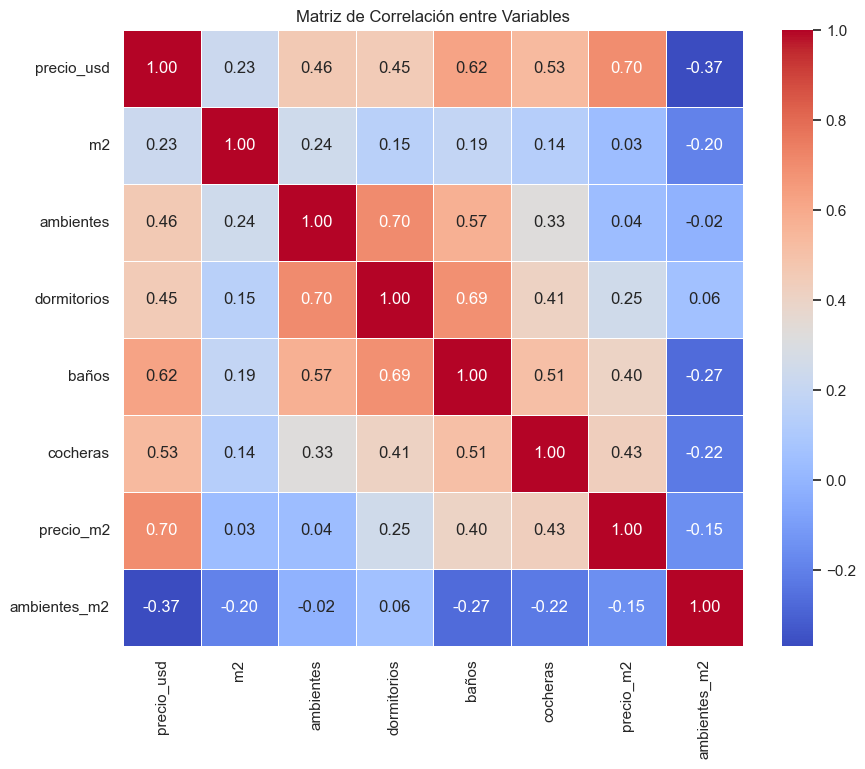

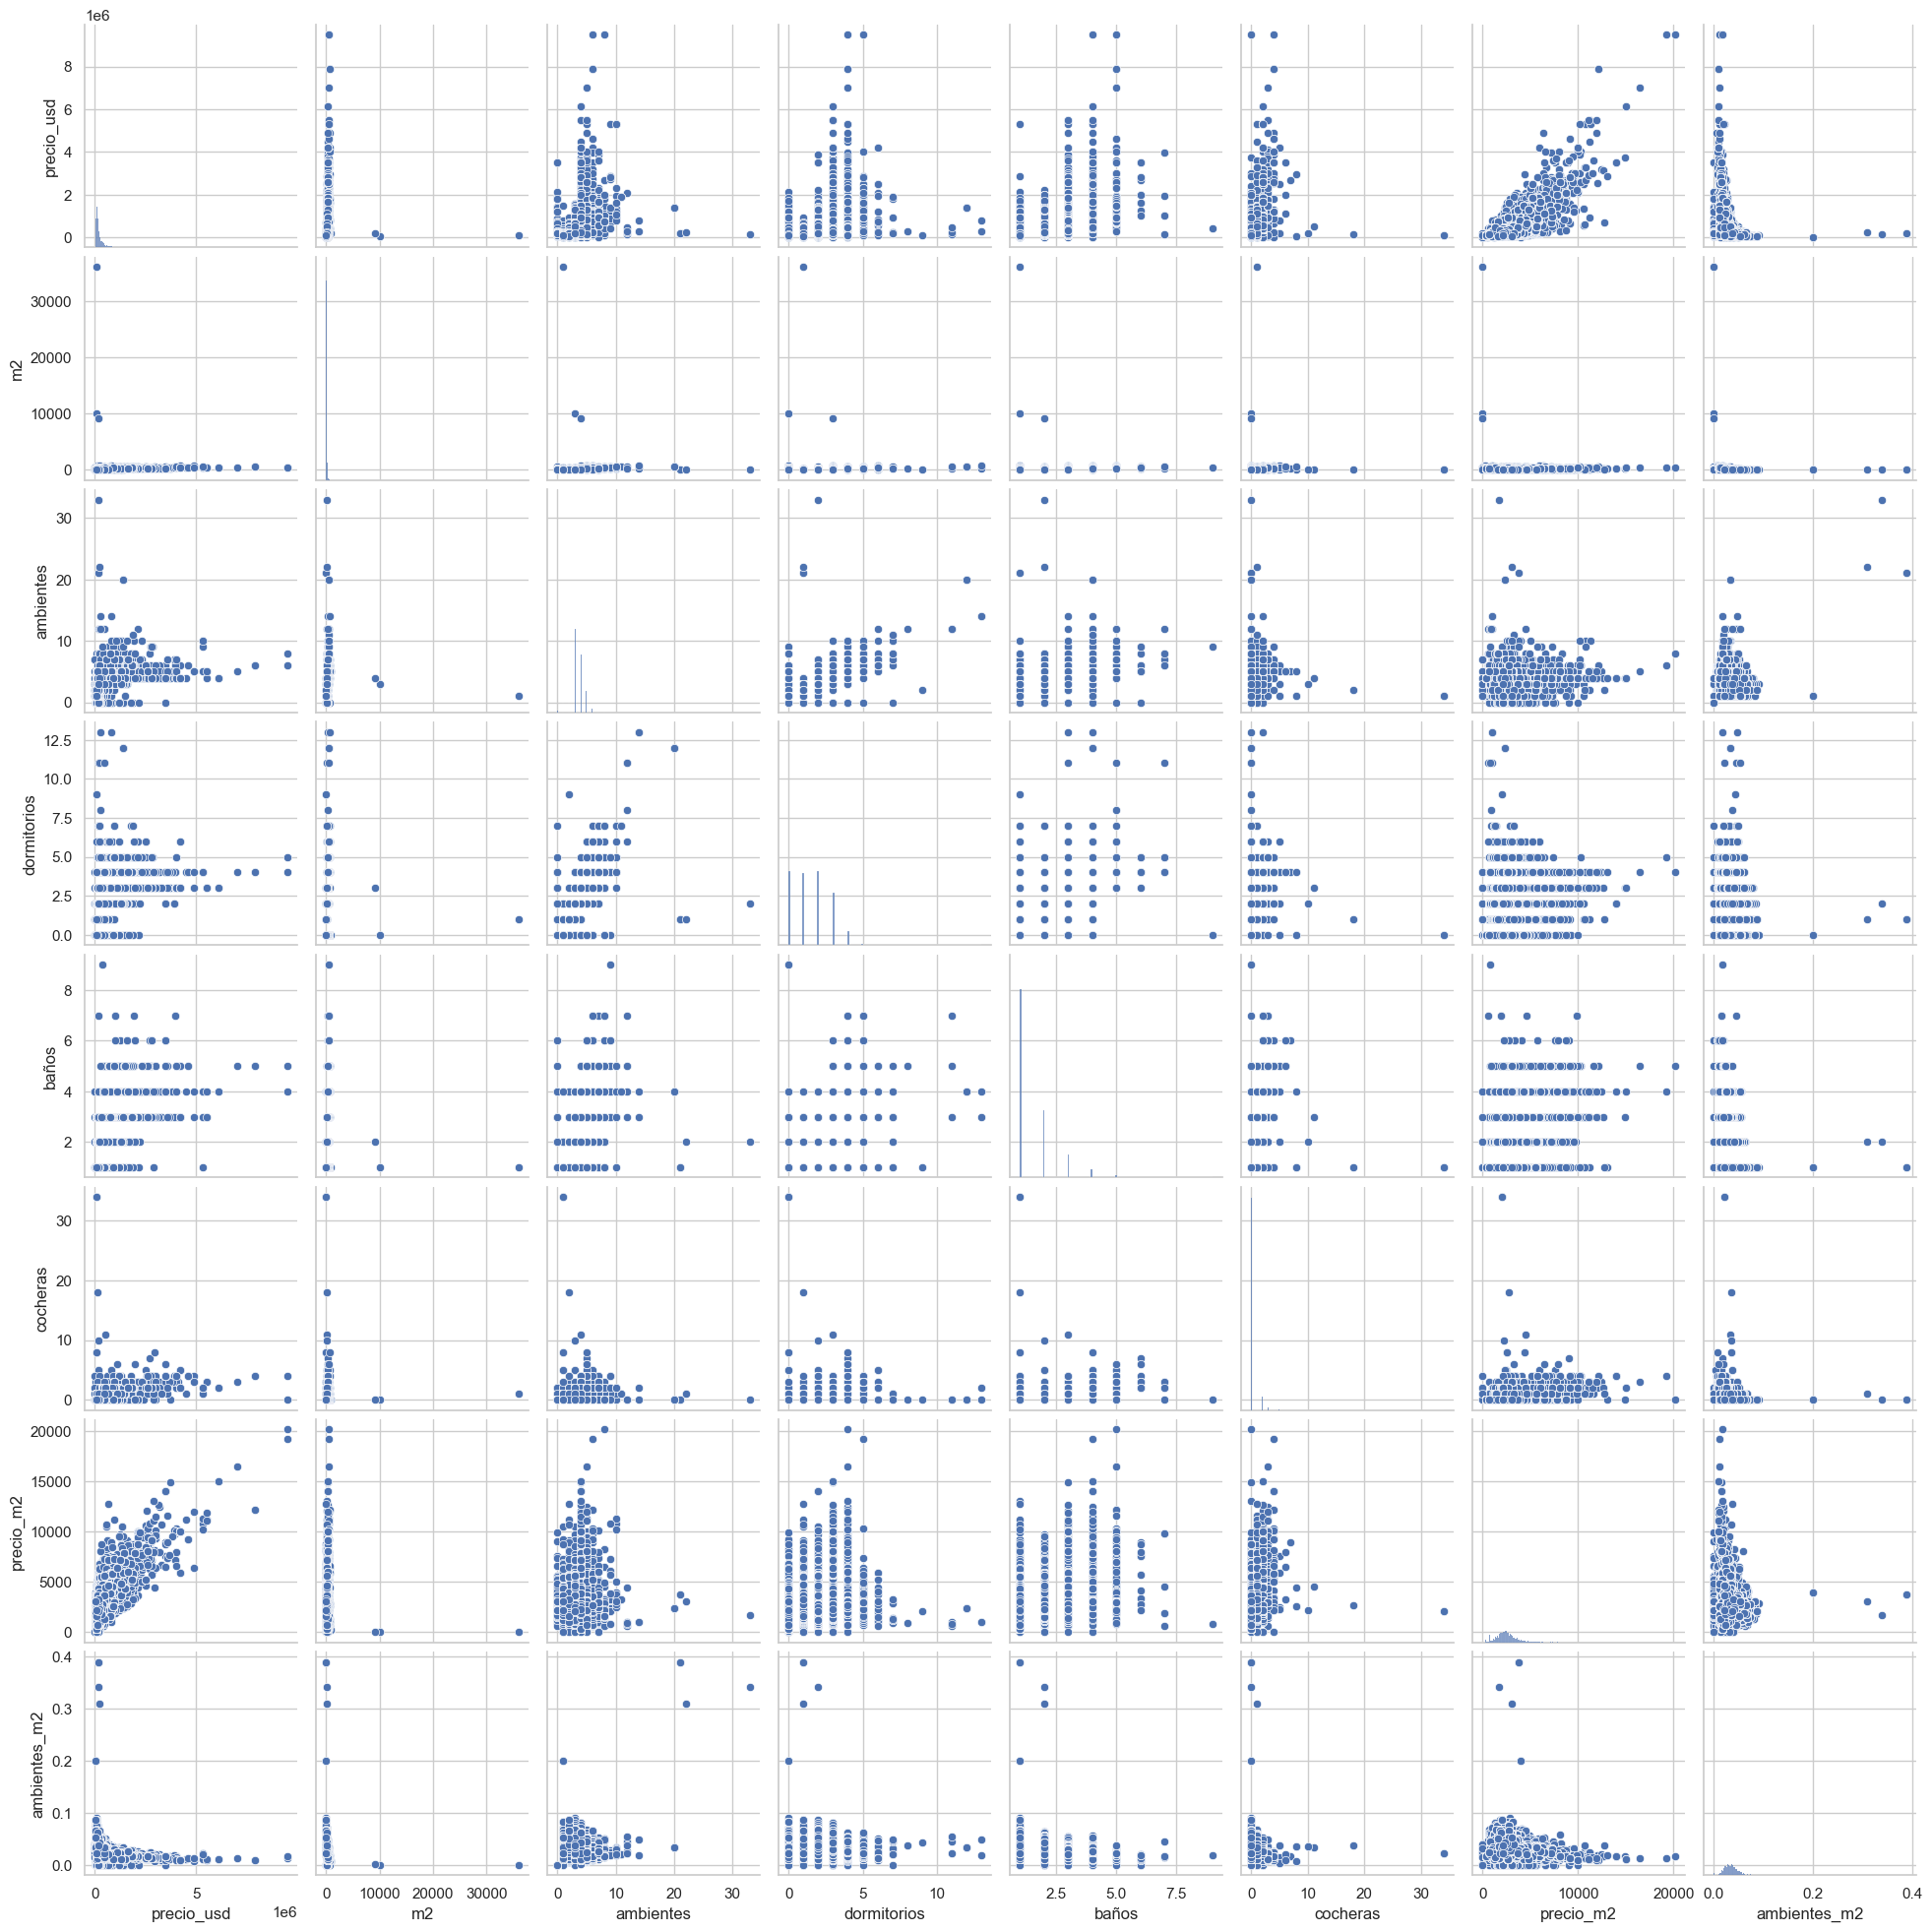

In [17]:
# Seleccionamos variables numéricas relevantes
vars_corr = ['precio_usd', 'm2', 'ambientes', 'dormitorios', 'baños', 'cocheras', 'precio_m2','ambientes_m2']
corr_matrix = df_clean[vars_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación entre Variables')
plt.show()

# Relaciones entre variables numéricas
sns.pairplot(df_clean)

## 4. Regresiones Lineales
Predicción del precio de propiedades utilizando regresiones lineales

### Limpieza de Outliers

In [ ]:
# Identificar Outliers
# Creamos un filtro 
filtro_outliers = (
    (df_clean['m2'] > 5000) | 
    (df_clean['cocheras'] > 6) | 
    (df_clean['baños'] > 6) | 
    (df_clean['ambientes'] > 12)
)

df_outliers = df_clean[filtro_outliers]

print(f"Se identificaron {len(df_outliers)} propiedades como outliers extremos.")
display(df_outliers.head(10))

# Extraer urls
urls_outliers = df_outliers['url']
for url in urls_outliers:
    print(url)

# Eliminar outliers
df_clean = df_clean.drop(df_outliers.index)

Se identificaron 0 propiedades como outliers extremos.


,precio_usd,ubicación,m2,ambientes,dormitorios,baños,cocheras,expensas,url


### Regresiones Lineales Simples

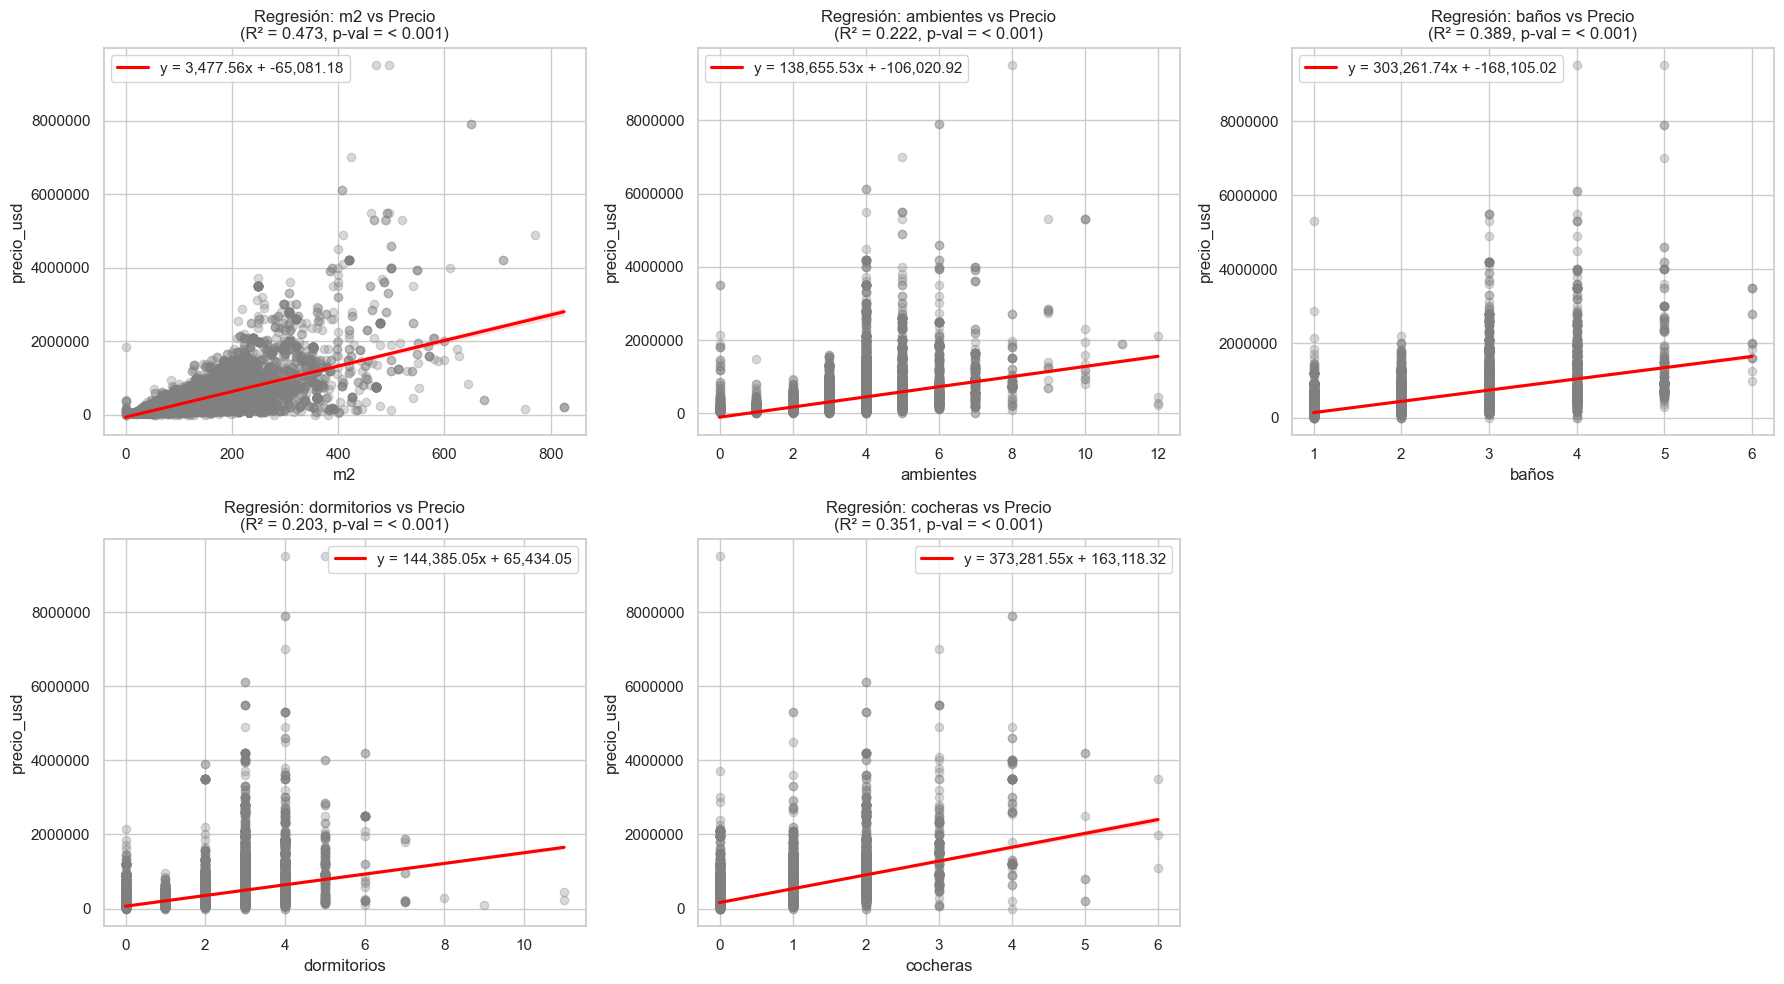

In [58]:
# Regresion Lineal Simple con R2 y p-value
variables = ['m2', 'ambientes', 'baños', 'dormitorios', 'cocheras']
target = 'precio_usd'

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(variables):
    X_simple = sm.add_constant(df_clean[[var]])
    y = df_clean[target]
    
    model_simple = sm.OLS(y, X_simple).fit()
    
    intercepto = model_simple.params['const']
    pendiente = model_simple.params[var]
    r2 = model_simple.rsquared
    
    # Extraer el p-value de la variable independiente (no de la constante)
    p_valor = model_simple.pvalues[var]
    
    # Formatear el p-value para que sea legible
    p_texto = f"{p_valor:.3f}" if p_valor >= 0.001 else "< 0.001"
    
    sns.regplot(ax=axes[i], x=var, y=target, data=df_clean, 
                scatter_kws={'alpha':0.3, 'color':'gray'}, 
                line_kws={'color':'red', 'label':f'y = {pendiente:,.2f}x + {intercepto:,.2f}'})
    
    # Añadir p-value al título
    axes[i].set_title(f'Regresión: {var} vs Precio\n(R² = {r2:.3f}, p-val = {p_texto})')
    axes[i].legend()
    axes[i].ticklabel_format(style='plain', axis='y') 

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()


### Regresiones Lineales Multiples 